In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp

import torch
from torch import nn, optim
from torch.utils import data as dt




In [3]:
data = pd.read_csv('dataset/opsd_raw.csv')

In [4]:
column_names = ["utc_timestamp", "DK_load_actual_entsoe_transparency", "DK_solar_generation_actual", "DK_wind_generation_actual"]
filtered_data = data[column_names]

In [4]:
filtered_data.shape

(50400, 4)

In [5]:
filtered_data['utc_timestamp'] = pd.to_datetime(filtered_data['utc_timestamp'])
filtered_data.set_index('utc_timestamp', inplace=True)

filtered_data_filled = filtered_data.interpolate(method='time')
filtered_data_filled = filtered_data_filled.fillna(method='ffill').fillna(method='bfill')

/var/folders/f3/cxyjx9753sqbgjvg64rxb3rh0000gn/T/ipykernel_20527/3597298546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['utc_timestamp'] = pd.to_datetime(filtered_data['utc_timestamp'])
/var/folders/f3/cxyjx9753sqbgjvg64rxb3rh0000gn/T/ipykernel_20527/3597298546.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_data_filled = filtered_data_filled.fillna(method='ffill').fillna(method='bfill')


In [6]:
def get_season(date):
    # Meteorological seasons
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [7]:
# Aggregate data into daily chunks (lists of 24 hourly values)
daily_data = filtered_data_filled.groupby(pd.Grouper(freq='D')).agg(list)

# Keep only complete daily records (i.e., 24 hourly entries for load)
daily_data = daily_data[daily_data['DK_load_actual_entsoe_transparency'].apply(len) == 24]

In [8]:
daily_data.head(5)

,DK_load_actual_entsoe_transparency,DK_solar_generation_actual,DK_wind_generation_actual
utc_timestamp,,,
2015-01-01 00:00:00+00:00,"[3100.02, 3100.02, 2980.39, 2933.49, 2941.54, ...","[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...","[2357.33, 2357.33, 2387.35, 2594.47, 3092.01, ..."
2015-01-02 00:00:00+00:00,"[2996.22, 2942.88, 2944.18, 3019.46, 3104.17, ...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.06, ...","[3231.6, 3212.27, 3188.93, 3167.6, 3425.92, 42..."
2015-01-03 00:00:00+00:00,"[3277.54, 3116.86, 3041.39, 3015.66, 3078.47, ...","[0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.06, 9...","[4018.64, 4039.56, 3905.82, 3714.39, 3645.2, 3..."
2015-01-04 00:00:00+00:00,"[3058.45, 2963.9, 2949.49, 2961.16, 2977.69, 3...","[0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.53, 23...","[2826.29, 2846.83, 2940.79, 2938.14, 2821.14, ..."
2015-01-05 00:00:00+00:00,"[3079.55, 2973.79, 2944.5, 3001.08, 3311.06, 4...","[0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.1, 4...","[2320.43, 2210.96, 1963.76, 1741.78, 1615.43, ..."


In [8]:
# Convert lists to numpy arrays for each column separately
load_data = np.array(daily_data['DK_load_actual_entsoe_transparency'].tolist())
solar_data = np.array(daily_data['DK_solar_generation_actual'].tolist())
wind_data = np.array(daily_data['DK_wind_generation_actual'].tolist())

# Create the flattened array by concatenating along axis 1
X = pd.DataFrame(np.concatenate([load_data, solar_data, wind_data], axis=1))

# Create labels
daily_data["season"] = daily_data.index.map(get_season).values

In [9]:
# Count how many daily samples fall into each season
season_counts = daily_data['season'].value_counts()
print(season_counts)

season
Spring    552
Summer    552
Winter    511
Fall      485
Name: count, dtype: int64


In [10]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(daily_data['season'])

In [11]:
# First split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y 
)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


In [13]:

winter_data = daily_data[daily_data["season"]=="Winter"].iloc[0]
spring_data = daily_data[daily_data["season"]=="Spring"].iloc[0]
summer_data = daily_data[daily_data["season"]=="Summer"].iloc[0]
fall_data = daily_data[daily_data["season"]=="Fall"].iloc[0]

# Create a 2x2 subplot grid
fig = sp.make_subplots(
    rows=2, 
    cols=2,
    subplot_titles=("Winter", "Spring", "Summer", "Fall"),
    vertical_spacing=0.1,
    horizontal_spacing=0.1
)

# Add each plot to the subplot grid
fig.add_trace(
    px.line(x=range(1, 25), y=winter_data["DK_load_actual_entsoe_transparency"]).data[0],
    row=1, col=1
)

fig.add_trace(
    px.line(x=range(1, 25), y=spring_data["DK_load_actual_entsoe_transparency"]).data[0],
    row=1, col=2
)

fig.add_trace(
    px.line(x=range(1, 25), y=summer_data["DK_load_actual_entsoe_transparency"]).data[0],
    row=2, col=1
)

fig.add_trace(
    px.line(x=range(1, 25), y=fall_data["DK_load_actual_entsoe_transparency"]).data[0],
    row=2, col=2
)

# Update layout for all subplots
fig.update_layout(
    height=800,
    width=1000,
    title_text="Daily Load Profiles by Season",
    showlegend=False,
    template="plotly_white"
)

# Add axis labels to all subplots
for i in range(1, 3):
    for j in range(1, 3):
        fig.update_xaxes(title_text="Hour of Day", row=i, col=j)
        fig.update_yaxes(title_text="Load (MW)", row=i, col=j)

# Show the plot
fig.show()

1. The highest load value is at Spring.
2. There is a trend of the highest load value near the middle of the day.

In [52]:
N_EPOCH = 65
BATCH_SIZE = 128

class FNN(nn.Module):
    
    def __init__(self,
                input_dim = 72, 
                hidden_dim = 128,
                output_dim = 4):
        
        # nn.module constructor
        super().__init__()

        # model layers
        self.model = nn.Sequential(
            # (batch_size, 72) → (batch_size, 128)
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            # (batch_size, 128) → (batch_size, 4)
            nn.Linear(hidden_dim, output_dim)
        )

        # loss
        self.loss_fn = nn.CrossEntropyLoss()

        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self._device)

        # optimiser
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
    def device(self):
        return next(self.parameters()).device
    
    def train_step(self, X: pd.DataFrame, y: pd.DataFrame):
        self.train()
        X, y = X.to(self.device()), y.to(self.device())

        # prediction from forward pass
        pred = self.forward(X)

        # calculate loss
        loss = self.loss_fn(pred, y)
        acc = (pred.argmax(dim=1)==y).sum().item()/len(y)


        self.optimizer.zero_grad()
        # compute derivatives
        loss.backward()
        self.optimizer.step()

        return loss.item(), acc

    def eval_step(self, X: pd.DataFrame, y: pd.DataFrame):
        self.eval()
        X, y = X.to(self.device()), y.to(self.device())

        with torch.no_grad():
            pred = self.forward(X)
            loss = self.loss_fn(pred, y)
            acc = (pred.argmax(dim=1)==y).sum().item()/len(y)

        return pred.argmax(dim=1), loss.item(), acc
    
    def fit(self,
            X_train, y_train,
            X_val, y_val,
            n_epoch = N_EPOCH):
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)

        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)  

        dataset_train = dt.TensorDataset(X_train, y_train)
        dataset_val = dt.TensorDataset(X_val, y_val)

        train_loader = dt.DataLoader(
            dataset_train,
            batch_size=BATCH_SIZE,
            shuffle=True,
            )
        val_loader = dt.DataLoader(
            dataset_val,
            batch_size=BATCH_SIZE,
            shuffle=True,
            )
        
        train_losses = []
        val_losses = []
        train_acc = []
        val_acc = []
        for epoch in range(N_EPOCH):
            train_losses_epoches = []
            train_acc_epoches = []
            for X_batch, y_batch in train_loader:
                loss, acc = self.train_step(X_batch, y_batch)
                train_losses_epoches.append(loss)
                train_acc_epoches.append(acc)

            val_losses_epoches = []
            val_acc_epoches = []
            for X_batch, y_batch in val_loader:
                pred, loss, acc = self.eval_step(X_batch, y_batch)
                val_losses_epoches.append(loss)
                val_acc_epoches.append(acc)

            print(f"Epoch {epoch + 1}/{n_epoch} | "
                  f"Train Loss: {sum(train_losses_epoches)/len(train_losses_epoches):.4f} | "
                  f"Val Acc: {sum(val_acc_epoches)/len(val_acc_epoches):.2f}%")
            
            train_losses.append(np.mean(train_losses_epoches))
            train_acc.append(np.mean(train_acc_epoches))
            val_losses.append(np.mean(val_losses_epoches))
            val_acc.append(np.mean(val_acc_epoches))  

        return train_losses, val_losses, train_acc, val_acc      

    def score(self,
              X_test, y_test):
        
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.long) 
        dataset_test = dt.TensorDataset(X_test, y_test)
        test_loader = dt.DataLoader(dataset_test, batch_size=BATCH_SIZE)

        correct_preds = 0  # Counter for correct predictions
        total_preds = 0    # Counter for total predictions
        preds = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                pred, _, _ = self.eval_step(X_batch, y_batch)
                correct_preds += (pred == y_batch).sum().item()  # Count correct predictions
                total_preds += y_batch.size(0)  # Increment total predictions
                preds.extend(pred.cpu().numpy())  # Collect all predictions

        # Calculate accuracy as the ratio of correct predictions to total predictions
        accuracy = correct_preds / total_preds
        return accuracy, preds


In [53]:
model = FNN()
train_losses, val_losses, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val)

Epoch 1/65 | Train Loss: 1.2010 | Val Acc: 0.56%
Epoch 2/65 | Train Loss: 0.9702 | Val Acc: 0.59%
Epoch 3/65 | Train Loss: 0.8632 | Val Acc: 0.65%
Epoch 4/65 | Train Loss: 0.7968 | Val Acc: 0.68%
Epoch 5/65 | Train Loss: 0.7430 | Val Acc: 0.71%
Epoch 6/65 | Train Loss: 0.7000 | Val Acc: 0.70%
Epoch 7/65 | Train Loss: 0.6713 | Val Acc: 0.72%
Epoch 8/65 | Train Loss: 0.6372 | Val Acc: 0.72%
Epoch 9/65 | Train Loss: 0.6109 | Val Acc: 0.73%
Epoch 10/65 | Train Loss: 0.5934 | Val Acc: 0.74%
Epoch 11/65 | Train Loss: 0.5790 | Val Acc: 0.73%
Epoch 12/65 | Train Loss: 0.5625 | Val Acc: 0.75%
Epoch 13/65 | Train Loss: 0.5481 | Val Acc: 0.75%
Epoch 14/65 | Train Loss: 0.5311 | Val Acc: 0.75%
Epoch 15/65 | Train Loss: 0.5246 | Val Acc: 0.76%
Epoch 16/65 | Train Loss: 0.5116 | Val Acc: 0.76%
Epoch 17/65 | Train Loss: 0.5042 | Val Acc: 0.76%
Epoch 18/65 | Train Loss: 0.4906 | Val Acc: 0.77%
Epoch 19/65 | Train Loss: 0.4822 | Val Acc: 0.77%
Epoch 20/65 | Train Loss: 0.4738 | Val Acc: 0.76%
Epoch 21/

In [54]:
score_test, preds = model.score(X_test, y_test)
score_val, _ = model.score(X_val,y_val)

In [55]:
print("On test set: " + str(score_test) + " accuracy")
print("On validation set: " + str(score_val) + " accuracy")

On test set: 0.8380952380952381 accuracy
On validation set: 0.8253968253968254 accuracy


In [56]:
cm1 = confusion_matrix(preds, y_test)

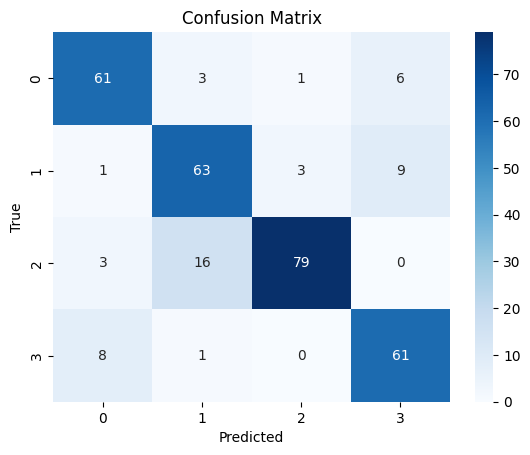

In [57]:
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
        # Plotting training loss and accuracy curves
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot loss
        ax[0].plot(train_losses, label="Train Loss")
        ax[0].plot(val_losses, label="Val Loss")
        ax[0].set_title('Training and Validation Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Plot accuracy
        ax[1].plot(train_accs, label="Train Accuracy")
        ax[1].plot(val_accs, label="Val Accuracy")
        ax[1].set_title('Training and Validation Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()

        plt.tight_layout()
        plt.show()

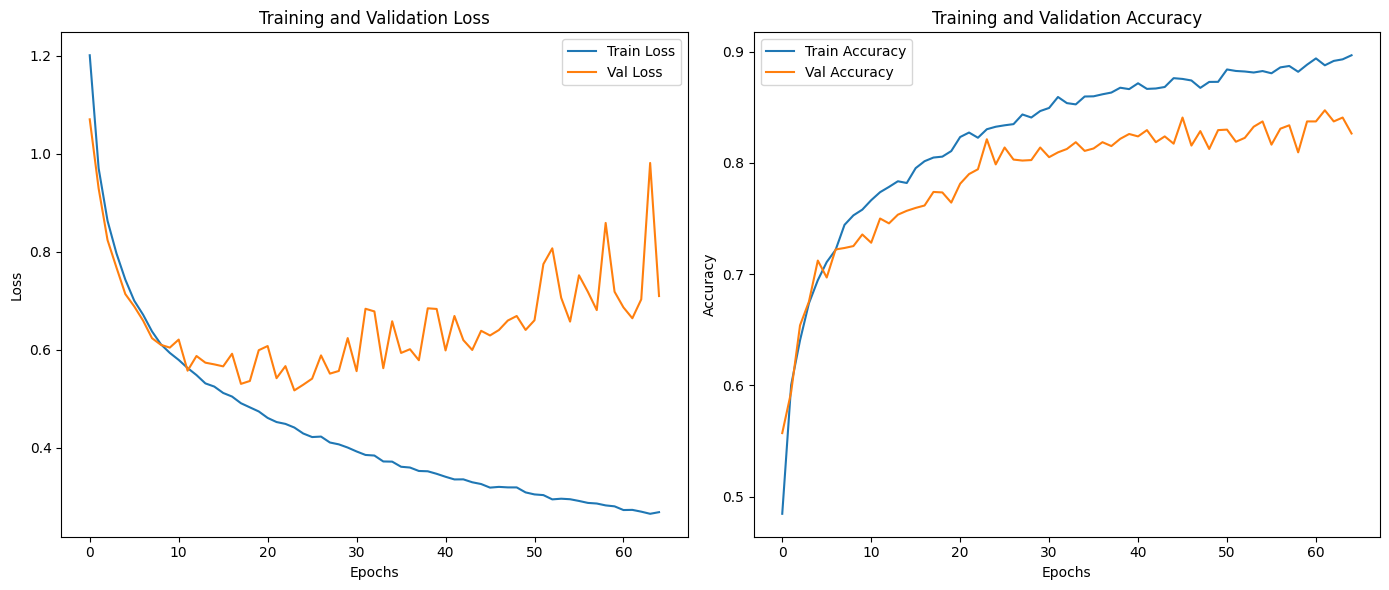

In [59]:
plot_training_curves(train_losses, val_losses, train_acc, val_acc)

In [60]:
STRIDE_SIZE = 1
KERNEL_SIZE = 3
N_EPOCH = 100
BATCH_SIZE = 64

class CNN_1D(nn.Module):
    
    def __init__(self,
                input_ch = 3,
                output_dim = 4,
                 ):
        
        super().__init__()

        self.model = nn.Sequential(
            # (batch_size, 3, 24) → (batch_size, 64, 24)
            nn.Conv1d(in_channels=input_ch, out_channels=64, kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE-1)//2),
            nn.ReLU(),

            # (batch_size, 64, 24) → (batch_size, 64, 12)
            nn.MaxPool1d(kernel_size=2),

            # (batch_size, 64, 12) → (batch_size, 128, 12)
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE-1)//2),
            nn.ReLU(),

            # (batch_size, 128, 12) → (batch_size, 128, 6)
            nn.MaxPool1d(kernel_size=2),

            nn.Dropout(),

            # (batch_size, 128, 6) → (batch_size, 256, 6)
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE-1)//2),
            nn.ReLU(),

            # (batch_size, 256, 6) → (batch_size, 256, 3)
            nn.MaxPool1d(kernel_size=2),

            nn.Dropout(),

            # Flatten: (batch_size, 256, 3) → (batch_size, 768)
            nn.Flatten(),

            # (batch_size, 768) → (batch_size, 4)
            nn.Linear(in_features=256*3, out_features=output_dim)
        )

        self.loss_fn = nn.CrossEntropyLoss()

        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self._device)

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape(x.shape[0], 3, 24)
        return self.model(x)

    def device(self):
        return next(self.parameters()).device
    
    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        self.model.train()
        x, y = x.to(self.device()), y.to(self.device())
        pred = self.forward(x)
        loss = self.loss_fn(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item(), (pred.argmax(dim=1)==y).sum().item()/len(y)

    def eval_step(self, X: pd.DataFrame, y: pd.DataFrame):
        self.eval()
        X, y = X.to(self.device()), y.to(self.device())

        with torch.no_grad():
            pred = self.forward(X)
            loss = self.loss_fn(pred, y)
            acc = (pred.argmax(dim=1)==y).sum().item()/len(y)

        return pred.argmax(dim=1), loss.item(), acc

    def fit(self,
            X_train, y_train,
            X_val, y_val,
            n_epoch = N_EPOCH):
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)

        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)  

        dataset_train = dt.TensorDataset(X_train, y_train)
        dataset_val = dt.TensorDataset(X_val, y_val)

        train_loader = dt.DataLoader(
            dataset_train,
            batch_size=BATCH_SIZE,
            shuffle=True,
            )
        val_loader = dt.DataLoader(
            dataset_val,
            batch_size=BATCH_SIZE,
            shuffle=True,
            )
        
        train_losses = []
        val_losses = []
        train_acc = []
        val_acc = []
        for epoch in range(N_EPOCH):
            train_losses_epoches = []
            train_acc_epoches = []
            for X_batch, y_batch in train_loader:
                loss, acc = self.train_step(X_batch, y_batch)
                train_losses_epoches.append(loss)
                train_acc_epoches.append(acc)

            val_losses_epoches = []
            val_acc_epoches = []
            for X_batch, y_batch in val_loader:
                pred, loss, acc = self.eval_step(X_batch, y_batch)
                val_losses_epoches.append(loss)
                val_acc_epoches.append(acc)

            print(f"Epoch {epoch + 1}/{n_epoch} | "
                  f"Train Loss: {sum(train_losses_epoches)/len(train_losses_epoches):.4f} | "
                  f"Val Acc: {sum(val_acc_epoches)/len(val_acc_epoches):.2f}%")
            
            train_losses.append(np.mean(train_losses_epoches))
            train_acc.append(np.mean(train_acc_epoches))
            val_losses.append(np.mean(val_losses_epoches))
            val_acc.append(np.mean(val_acc_epoches))  

        return train_losses, val_losses, train_acc, val_acc      

    def score(self,
              X_test, y_test):
        
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.long) 
        dataset_test = dt.TensorDataset(X_test, y_test)
        test_loader = dt.DataLoader(dataset_test, batch_size=BATCH_SIZE)

        correct_preds = 0  # Counter for correct predictions
        total_preds = 0    # Counter for total predictions
        preds = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                pred, _, _ = self.eval_step(X_batch, y_batch)
                correct_preds += (pred == y_batch).sum().item()  # Count correct predictions
                total_preds += y_batch.size(0)  # Increment total predictions
                preds.extend(pred.cpu().numpy())  # Collect all predictions

        # Calculate accuracy as the ratio of correct predictions to total predictions
        accuracy = correct_preds / total_preds
        return accuracy, preds

In [61]:
model = CNN_1D()
train_losses, val_losses, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val)

Epoch 1/100 | Train Loss: 1.0853 | Val Acc: 0.58%
Epoch 2/100 | Train Loss: 0.8983 | Val Acc: 0.63%
Epoch 3/100 | Train Loss: 0.8252 | Val Acc: 0.67%
Epoch 4/100 | Train Loss: 0.7730 | Val Acc: 0.71%
Epoch 5/100 | Train Loss: 0.7344 | Val Acc: 0.69%
Epoch 6/100 | Train Loss: 0.7004 | Val Acc: 0.73%
Epoch 7/100 | Train Loss: 0.6575 | Val Acc: 0.72%
Epoch 8/100 | Train Loss: 0.6283 | Val Acc: 0.75%
Epoch 9/100 | Train Loss: 0.6139 | Val Acc: 0.74%
Epoch 10/100 | Train Loss: 0.5990 | Val Acc: 0.75%
Epoch 11/100 | Train Loss: 0.5786 | Val Acc: 0.79%
Epoch 12/100 | Train Loss: 0.5573 | Val Acc: 0.77%
Epoch 13/100 | Train Loss: 0.5468 | Val Acc: 0.79%
Epoch 14/100 | Train Loss: 0.5126 | Val Acc: 0.79%
Epoch 15/100 | Train Loss: 0.5115 | Val Acc: 0.80%
Epoch 16/100 | Train Loss: 0.5182 | Val Acc: 0.79%
Epoch 17/100 | Train Loss: 0.4869 | Val Acc: 0.80%
Epoch 18/100 | Train Loss: 0.4784 | Val Acc: 0.76%
Epoch 19/100 | Train Loss: 0.4607 | Val Acc: 0.82%
Epoch 20/100 | Train Loss: 0.4601 | Val 

In [62]:
score_test, preds = model.score(X_test, y_test)
score_val, _ = model.score(X_val,y_val)

In [64]:
print("On test set: " + str(score_test) + " accuracy")
print("On validation set: " + str(score_val) + " accuracy")

On test set: 0.8698412698412699 accuracy
On validation set: 0.8634920634920635 accuracy


In [65]:
cm2 = confusion_matrix(preds, y_test)

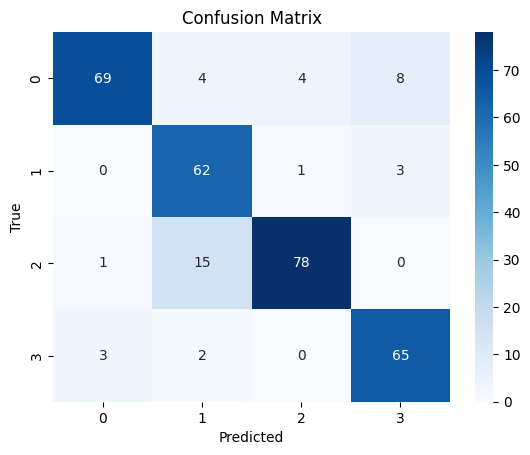

In [66]:
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

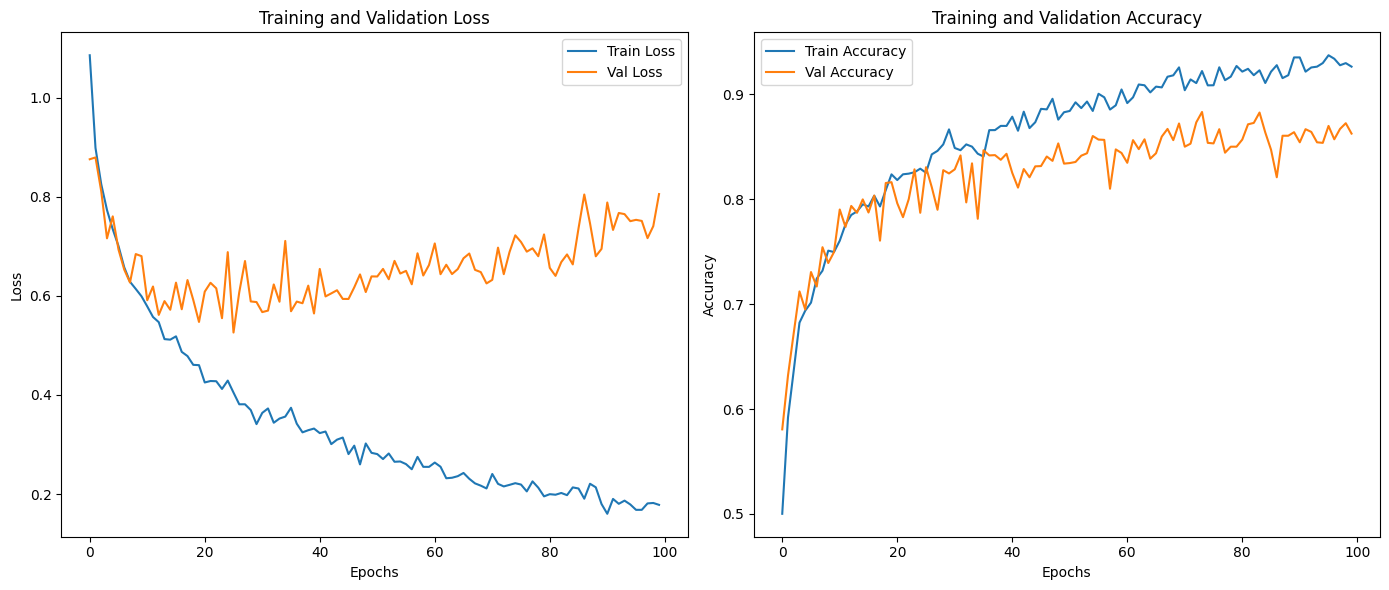

In [67]:
plot_training_curves(train_losses, val_losses, train_acc, val_acc)

In [26]:
from pyts.image import GramianAngularField

STRIDE_SIZE = 1
KERNEL_SIZE = 3
N_EPOCH = 20
BATCH_SIZE = 64


def transform_to_gaf_images(X_raw: np.ndarray, image_size: int = 24):

    n_samples, n_channels, ts_length = X_raw.shape
    gaf = GramianAngularField(image_size=image_size, method='summation')
    X_gaf = np.zeros((n_samples, n_channels, image_size, image_size))

    for i in range(n_samples):
        for ch in range(n_channels):
            ts = X_raw[i, ch]
            X_gaf[i, ch] = gaf.fit_transform(ts.reshape(1, -1))[0]

    return X_gaf


class CNN_2D(nn.Module):

    def __init__(self, input_ch=3, output_dim=4):
        super().__init__()

        self.model = nn.Sequential(
            # (batch_size, 3, 24, 24) -> (batch_size, 64, 24, 24)
            nn.Conv2d(in_channels=input_ch, out_channels=64,
                      kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE - 1) // 2),
            nn.ReLU(),

            # (batch_size, 64, 24, 24) -> (batch_size, 128, 24, 24)
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=KERNEL_SIZE, padding=(KERNEL_SIZE - 1) // 2),
            nn.ReLU(),

            # (batch_size, 128, 24, 24) -> (batch_size, 128, 12, 12)
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(),

            # (batch_size, 128, 12, 12) -> (batch_size, 18432)
            nn.Flatten(),

            # (batch_size, 18432) -> (batch_size, 64)
            nn.Linear(in_features=128 * 12 * 12, out_features=64),
            nn.ReLU(),

            # (batch_size, 64) -> (batch_size, 4)
            nn.Linear(in_features=64, out_features=output_dim)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self._device)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def device(self):
        return next(self.parameters()).device

    def train_step(self, x: torch.Tensor, y: torch.Tensor):
        self.model.train()
        x, y = x.to(self.device()), y.to(self.device())
        pred = self.forward(x)
        loss = self.loss_fn(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item(), (pred.argmax(dim=1) == y).sum().item() / len(y)

    def eval_step(self, X: torch.Tensor, y: torch.Tensor):
        self.eval()
        X, y = X.to(self.device()), y.to(self.device())
        with torch.no_grad():
            pred = self.forward(X)
            loss = self.loss_fn(pred, y)
            acc = (pred.argmax(dim=1) == y).sum().item() / len(y)
        return pred.argmax(dim=1), loss.item(), acc

    def fit(self, X_train, y_train, X_val, y_val, n_epoch=N_EPOCH):
        # Reshape flat vector (n_samples, 72) → (n_samples, 3, 24)
        X_train = X_train.reshape(-1, 3, 24)
        X_val = X_val.reshape(-1, 3, 24)

        # Apply GAF transformation
        X_train = transform_to_gaf_images(X_train)
        X_val = transform_to_gaf_images(X_val)

        # Convert to tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)

        dataset_train = dt.TensorDataset(X_train, y_train)
        dataset_val = dt.TensorDataset(X_val, y_val)
        train_loader = dt.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = dt.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        for epoch in range(N_EPOCH):
            train_losses_epoches = []
            train_acc_epoches = []
            for X_batch, y_batch in train_loader:
                loss, acc = self.train_step(X_batch, y_batch)
                train_losses_epoches.append(loss)
                train_acc_epoches.append(acc)

            val_losses_epoches = []
            val_acc_epoches = []
            for X_batch, y_batch in val_loader:
                _, loss, acc = self.eval_step(X_batch, y_batch)
                val_losses_epoches.append(loss)
                val_acc_epoches.append(acc)

            print(f"Epoch {epoch + 1}/{n_epoch} | "
                  f"Train Loss: {np.mean(train_losses_epoches):.4f} | "
                  f"Val Acc: {np.mean(val_acc_epoches) * 100:.2f}%")

            train_losses.append(np.mean(train_losses_epoches))
            train_acc.append(np.mean(train_acc_epoches))
            val_losses.append(np.mean(val_losses_epoches))
            val_acc.append(np.mean(val_acc_epoches))

        return train_losses, val_losses, train_acc, val_acc

    def score(self, X_test, y_test):
        # Reshape flat vector (n_samples, 72) → (n_samples, 3, 24)
        X_test = X_test.reshape(-1, 3, 24)
        X_test = transform_to_gaf_images(X_test)

        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.long)
        dataset_test = dt.TensorDataset(X_test, y_test)
        test_loader = dt.DataLoader(dataset_test, batch_size=BATCH_SIZE)

        correct_preds = 0
        total_preds = 0
        preds = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                pred, _, _ = self.eval_step(X_batch, y_batch)
                correct_preds += (pred == y_batch).sum().item()
                total_preds += y_batch.size(0)
                preds.extend(pred.cpu().numpy())

        accuracy = correct_preds / total_preds
        return accuracy, preds

In [27]:
model = CNN_2D()
train_losses, val_losses, train_acc, val_acc = model.fit(X_train, y_train, X_val, y_val)
score_test, preds = model.score(X_test, y_test)
score_val, _ = model.score(X_val,y_val)

Epoch 1/20 | Train Loss: 1.1494 | Val Acc: 62.31%
Epoch 2/20 | Train Loss: 0.7513 | Val Acc: 73.41%
Epoch 3/20 | Train Loss: 0.6106 | Val Acc: 74.60%
Epoch 4/20 | Train Loss: 0.5041 | Val Acc: 78.67%
Epoch 5/20 | Train Loss: 0.4484 | Val Acc: 77.42%
Epoch 6/20 | Train Loss: 0.3930 | Val Acc: 79.58%
Epoch 7/20 | Train Loss: 0.3307 | Val Acc: 80.18%
Epoch 8/20 | Train Loss: 0.2812 | Val Acc: 80.59%
Epoch 9/20 | Train Loss: 0.2436 | Val Acc: 80.51%
Epoch 10/20 | Train Loss: 0.2168 | Val Acc: 80.39%
Epoch 11/20 | Train Loss: 0.1755 | Val Acc: 79.22%
Epoch 12/20 | Train Loss: 0.1522 | Val Acc: 79.14%
Epoch 13/20 | Train Loss: 0.1488 | Val Acc: 79.99%
Epoch 14/20 | Train Loss: 0.1346 | Val Acc: 79.42%
Epoch 15/20 | Train Loss: 0.1076 | Val Acc: 80.13%
Epoch 16/20 | Train Loss: 0.0865 | Val Acc: 80.28%
Epoch 17/20 | Train Loss: 0.1079 | Val Acc: 77.49%
Epoch 18/20 | Train Loss: 0.1089 | Val Acc: 80.67%
Epoch 19/20 | Train Loss: 0.0920 | Val Acc: 80.02%
Epoch 20/20 | Train Loss: 0.0705 | Val A

In [25]:
print("On test set: " + str(score_test) + " accuracy")
print("On validation set: " + str(score_val) + " accuracy")

On test set: 0.7904761904761904 accuracy
On validation set: 0.8095238095238095 accuracy


In [21]:
cm3 = confusion_matrix(preds, y_test)

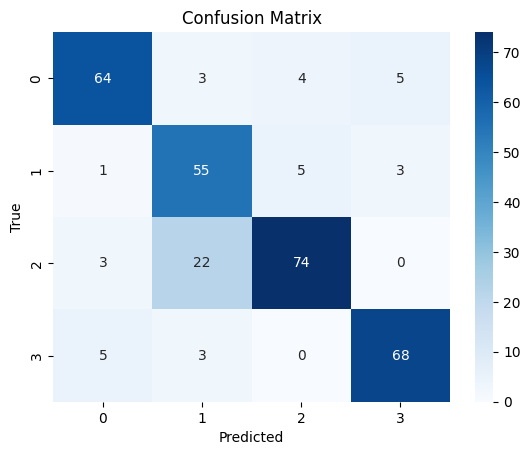

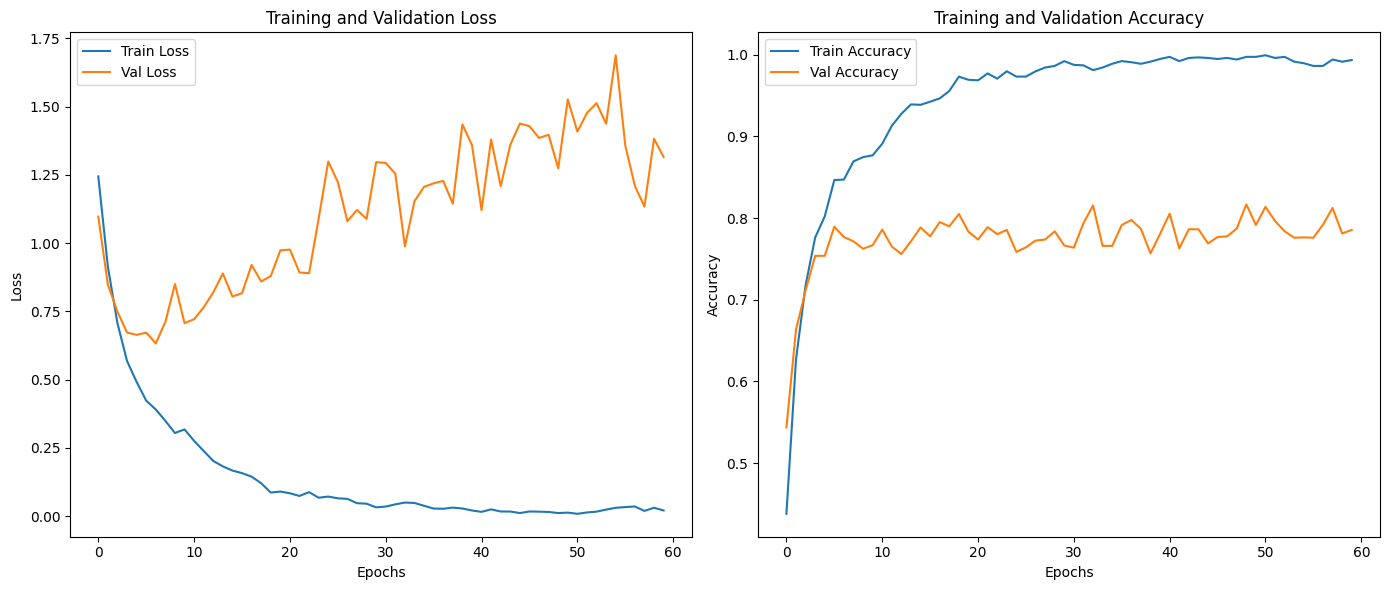

In [22]:
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plot_training_curves(train_losses, val_losses, train_acc, val_acc)